In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import math
import numpy as np
import sklearn as sk

pd.options.display.max_columns = None
# Data Initialization
flood_df = pd.read_csv('data/flooding_events_augmented.csv', dtype=str, keep_default_na=False)
non_flood_df = pd.read_csv('data/non_flooding_events_normal_augmented.csv', dtype=str, keep_default_na=False)

# Data engineering: Flood basin (based on lat/lon), Season

In [47]:
# Robust missing detector (so blanks like "", "NA", "null" count as missing)
MISSING_TOKENS = {"", " ", "na", "n/a", "null", "none", "nan"}
def is_na_like(s):
    s = str(s).strip().lower()
    return s in MISSING_TOKENS

In [48]:
KNOWN_NUMERIC = [
    "YEAR", "MONTH", "BEGIN_DAY", "BEGIN_TIME", "BEGIN_LAT", "BEGIN_LON", "temperature_2m_mean", 
    "wind_speed_10m_mean", "cloud_cover_mean", "relative_humidity_2m_mean", "dew_point_2m_mean", 
    "precipitation_sum", "rain_sum", "snowfall_sum", "pressure_msl_mean", "soil_moisture_0_to_10cm_mean", 
    "elevation"
]
def coerce_numeric(df):
    # Try to coerce known numeric columns; leave others as text
    present_numeric = [c for c in KNOWN_NUMERIC if c in df.columns]
    for c in present_numeric:
        df[c] = pd.to_numeric(df[c], errors='coerce')

In [49]:
coerce_numeric(flood_df)
coerce_numeric(non_flood_df)

In [50]:
def output_missing(df, name):
    miss_rows = []
    for c in df.columns:
        if c in [col for col in KNOWN_NUMERIC if col in df.columns]:
            miss = df[c].isna().sum()
        else:
            miss = df[c].apply(is_na_like).sum()
        miss_rows.append({"column": c, "missing": int(miss), "missing_%": round(miss*100/len(flood_df), 2)})
    miss_df = pd.DataFrame(miss_rows).sort_values("missing", ascending=False)
    print(f"\n=== MISSING VALUES (robust) for the {name} dataset ===")
    print(miss_df.to_string(index=False))

In [51]:
output_missing(flood_df, 'flood_df')
output_missing(non_flood_df, 'non_flood_df')


=== MISSING VALUES (robust) for the flood_df dataset ===
                      column  missing  missing_%
                snowfall_sum      997      10.67
                    rain_sum      997      10.67
                 FLOOD_CAUSE      526       5.63
             EVENT_NARRATIVE       93       1.00
soil_moisture_0_to_10cm_mean       32       0.34
                        YEAR        0       0.00
            cloud_cover_mean        0       0.00
           pressure_msl_mean        0       0.00
           precipitation_sum        0       0.00
           dew_point_2m_mean        0       0.00
   relative_humidity_2m_mean        0       0.00
         temperature_2m_mean        0       0.00
         wind_speed_10m_mean        0       0.00
                       MONTH        0       0.00
                  EVENT_TYPE        0       0.00
                       STATE        0       0.00
                   BEGIN_LON        0       0.00
                   BEGIN_LAT        0       0.00
           

In [52]:
def explore_data_shape(df, name):
    print(f"=== {name} DATA SHAPE & COLUMNS ===")
    print(f"Rows: {len(df):,}  |  Columns: {len(df.columns)}")
    print("Columns:", ", ".join(df.columns))
    print("\n=== HEAD(10) ===")
    print(df.head(10).to_string(index=False))
    print("\n=== TAIL(5) ===")
    print(df.tail(5).to_string(index=False))
    print('\n')

In [53]:
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

explore_data_shape(flood_df, 'flood_df')
explore_data_shape(non_flood_df, 'non_flood_df')

=== flood_df DATA SHAPE & COLUMNS ===
Rows: 9,340  |  Columns: 21
Columns: YEAR, MONTH, BEGIN_DAY, BEGIN_TIME, BEGIN_LAT, BEGIN_LON, STATE, EVENT_TYPE, FLOOD_CAUSE, EVENT_NARRATIVE, temperature_2m_mean, wind_speed_10m_mean, cloud_cover_mean, relative_humidity_2m_mean, dew_point_2m_mean, precipitation_sum, rain_sum, snowfall_sum, pressure_msl_mean, soil_moisture_0_to_10cm_mean, elevation

=== HEAD(10) ===
 YEAR  MONTH  BEGIN_DAY  BEGIN_TIME  BEGIN_LAT  BEGIN_LON STATE  EVENT_TYPE FLOOD_CAUSE                                                                           EVENT_NARRATIVE  temperature_2m_mean  wind_speed_10m_mean  cloud_cover_mean  relative_humidity_2m_mean  dew_point_2m_mean  precipitation_sum  rain_sum  snowfall_sum  pressure_msl_mean  soil_moisture_0_to_10cm_mean  elevation
 2001      3         11         140   32.53333  -96.66667 TEXAS Flash Flood                                                      Roads were closed near Sanger due to high water.            18.331040       

In [54]:
def describe_numeric(df, name):
    if [c for c in KNOWN_NUMERIC if c in df.columns]:
        desc = df[[c for c in KNOWN_NUMERIC if c in df.columns]].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
        desc = desc.rename(columns={"50%":"median"}).reset_index().rename(columns={"index":"column"})
        print(f"\n=== NUMERIC STATS (describe) for {name} ===")
        print(desc.round(3).to_string(index=False))
    else:
        print(f"\n(No numeric columns in {name} found to describe.)")

In [55]:
describe_numeric(flood_df, 'flood_df')
describe_numeric(non_flood_df, 'non_flood_df')


=== NUMERIC STATS (describe) for flood_df ===
                      column  count     mean     std      min       1%       5%      25%   median      75%      95%      99%      max
                        YEAR 9340.0 2014.298   5.945 2001.000 2004.000 2005.000 2009.000 2015.000 2019.000 2024.000 2025.000 2025.000
                       MONTH 9340.0    6.375   2.458    1.000    1.000    3.000    5.000    6.000    8.000   10.000   12.000   12.000
                   BEGIN_DAY 9340.0   16.600   8.940    1.000    1.000    2.000    9.000   17.000   25.000   30.000   31.000   31.000
                  BEGIN_TIME 9340.0 1227.021 664.690    0.000    0.000  115.000  700.000 1252.500 1813.000 2220.000 2331.000 2359.000
                   BEGIN_LAT 9340.0   31.183   2.019   25.818   26.161   27.670   29.780   31.407   32.702   34.065   35.428   36.464
                   BEGIN_LON 9340.0  -98.083   2.497 -106.636 -105.876 -102.379  -99.550  -97.732  -96.426  -94.410  -93.950  -93.219
         temper

In [56]:
def explore_categorical(df, name):
    cat_cols = ["EVENT_TYPE"]
    
    if cat_cols:
        print(f"\n=== CATEGORICAL STATS (describe for object) in {name} ===")
        print(df[cat_cols].describe(include=['object']).to_string())
        print(f"\n=== CATEGORICAL VALUE COUNTS (top 20 each) in {name} ===")
        for col in cat_cols:
            s = df[col].astype(str)
            s = s.where(~s.apply(is_na_like), "<MISSING>")
            vc = s.value_counts(dropna=False)
            top = vc.head(20)
            print("-"*100)
            print(f"{col} | distinct={vc.shape[0]} | top 20 shown")
            print(pd.DataFrame({"value": top.index, "count": top.values, "percent": (top.values/len(s)*100).round(2)}).to_string(index=False))
            ax = top.sort_values(ascending=True).plot.barh(figsize=(8, 0.3*len(top)), title=col)
            ax.set_xlabel("Count")
            plt.tight_layout()
            plt.show()
    else:
        print(f"\n(No categorical columns in {name} detected under current rules.)")


=== CATEGORICAL STATS (describe for object) in flood_df ===
         EVENT_TYPE
count          9340
unique            2
top     Flash Flood
freq           8022

=== CATEGORICAL VALUE COUNTS (top 20 each) in flood_df ===
----------------------------------------------------------------------------------------------------
EVENT_TYPE | distinct=2 | top 20 shown
      value  count  percent
Flash Flood   8022    85.89
      Flood   1318    14.11


/var/folders/sr/wl072k0j639gxnqc7g60nk0h0000gn/T/ipykernel_40131/3167055182.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


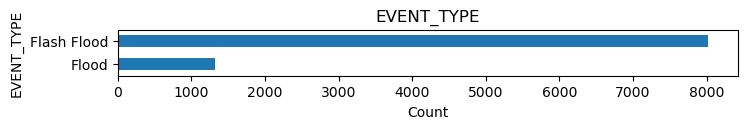


=== CATEGORICAL STATS (describe for object) in non_flood_df ===
       EVENT_TYPE
count        9340
unique          1
top        Normal
freq         9340

=== CATEGORICAL VALUE COUNTS (top 20 each) in non_flood_df ===
----------------------------------------------------------------------------------------------------
EVENT_TYPE | distinct=1 | top 20 shown
 value  count  percent
Normal   9340    100.0


/var/folders/sr/wl072k0j639gxnqc7g60nk0h0000gn/T/ipykernel_40131/3167055182.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


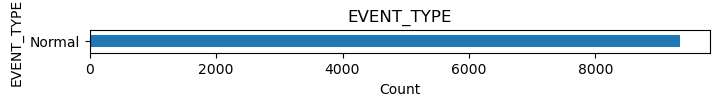

In [57]:
explore_categorical(flood_df, 'flood_df')
explore_categorical(non_flood_df, 'non_flood_df')

In [58]:
def explore_numeric(col, df, name, bins=50):
    print(f" --- {name} ---\n")
    if col not in df.columns:
        print(f"{col} not found"); return
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        print(f"{col}: no numeric data"); return
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    fig.suptitle(col)
    axes[0].hist(s, bins=bins); axes[0].set_title("Histogram"); axes[0].grid(True, alpha=0.3)
    axes[1].boxplot(s, vert=True, showfliers=True); axes[1].set_title("Boxplot"); axes[1].grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(s.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).round(3))

def visualize_categorical(col, df, name, top_n=30):
    print(f" --- {name} ---\n")
    if col not in df.columns:
        print(f"{col} not found"); return
    s_raw = df[col].astype(str)
    s = s_raw.where(~s_raw.apply(is_na_like), "<MISSING>")
    vc = s.value_counts()
    print(f"{col} | distinct={vc.shape[0]} | total={len(s)} | missing={(s=='<MISSING>').sum()}")
    show = vc.head(top_n)
    print(pd.DataFrame({
        "value": show.index,
        "count": show.values,
        "percent": (show.values/len(s)*100).round(2)
    }).to_string(index=False))
    ax = show.sort_values(ascending=True).plot.barh(figsize=(8, 0.3*len(show)), title=col)
    ax.set_xlabel("Count")
    plt.tight_layout()
    plt.show()

 --- flood_df ---



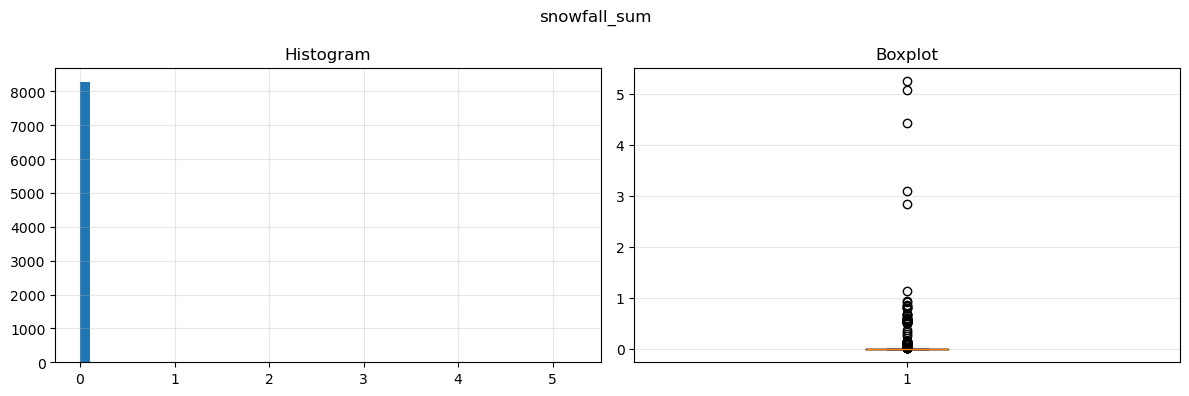

count    8343.000
mean        0.006
std         0.114
min         0.000
1%          0.000
5%          0.000
25%         0.000
50%         0.000
75%         0.000
95%         0.000
99%         0.000
max         5.247
Name: snowfall_sum, dtype: float64


In [59]:
explore_numeric("snowfall_sum", flood_df, 'flood_df')

 --- flood_df ---



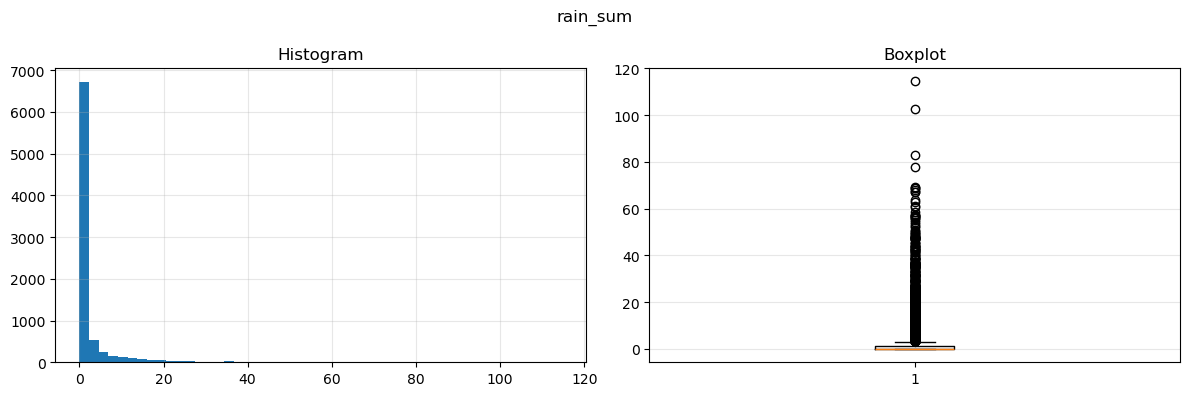

count    8343.000
mean        2.501
std         7.082
min         0.000
1%          0.000
5%          0.000
25%         0.000
50%         0.000
75%         1.261
95%        14.487
99%        36.113
max       114.628
Name: rain_sum, dtype: float64


In [60]:
explore_numeric("rain_sum", flood_df, 'flood_df')

 --- flood_df ---



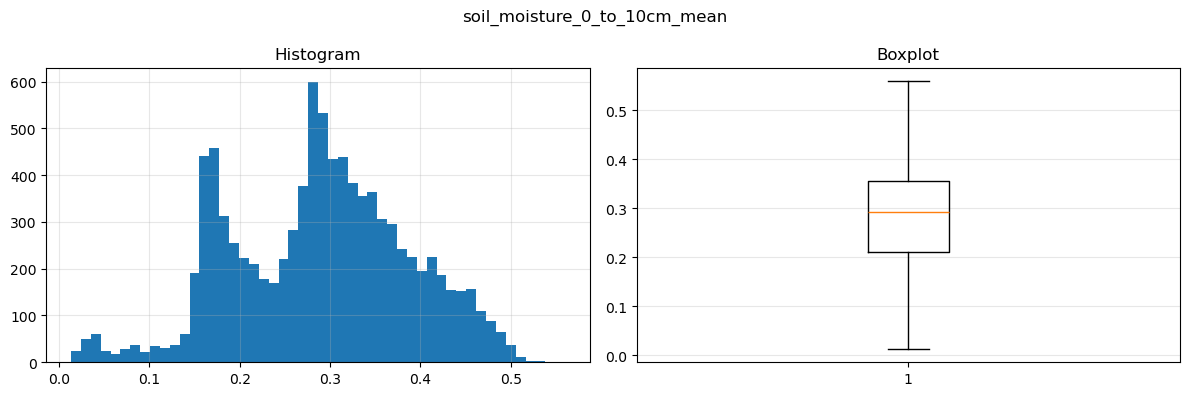

count    9308.000
mean        0.289
std         0.098
min         0.013
1%          0.039
5%          0.148
25%         0.212
50%         0.293
75%         0.357
95%         0.451
99%         0.487
max         0.560
Name: soil_moisture_0_to_10cm_mean, dtype: float64


In [61]:
explore_numeric("soil_moisture_0_to_10cm_mean", flood_df, 'flood_df')

 --- flood_df ---



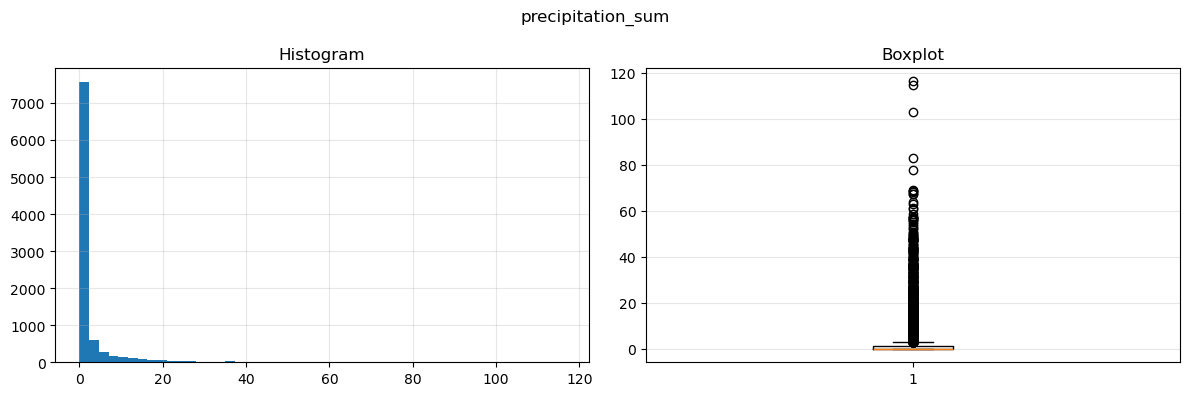

count    9340.000
mean        2.384
std         6.945
min         0.000
1%          0.000
5%          0.000
25%         0.000
50%         0.000
75%         1.164
95%        14.000
99%        35.967
max       116.481
Name: precipitation_sum, dtype: float64


In [62]:
explore_numeric("precipitation_sum", flood_df, 'flood_df')

In [63]:
def clean_data(df):
    df.drop('snowfall_sum', axis=1, inplace=True)
    df.drop('BEGIN_DAY', axis=1, inplace=True)

    df.dropna(subset=['soil_moisture_0_to_10cm_mean'], inplace=True)

    df = df.sort_values('precipitation_sum')
    df['rain_sum'] = df['rain_sum'].interpolate(method='nearest')
    df = df.sort_index()

    return df

In [64]:
flood_df = clean_data(flood_df)
non_flood_df = clean_data(non_flood_df)

In [65]:
output_missing(flood_df, 'flood_df')
output_missing(non_flood_df, 'non_flood_df')


=== MISSING VALUES (robust) for the flood_df dataset ===
                      column  missing  missing_%
                 FLOOD_CAUSE      526       5.65
             EVENT_NARRATIVE       93       1.00
                        YEAR        0       0.00
            cloud_cover_mean        0       0.00
soil_moisture_0_to_10cm_mean        0       0.00
           pressure_msl_mean        0       0.00
                    rain_sum        0       0.00
           precipitation_sum        0       0.00
           dew_point_2m_mean        0       0.00
   relative_humidity_2m_mean        0       0.00
         temperature_2m_mean        0       0.00
         wind_speed_10m_mean        0       0.00
                       MONTH        0       0.00
                  EVENT_TYPE        0       0.00
                       STATE        0       0.00
                   BEGIN_LON        0       0.00
                   BEGIN_LAT        0       0.00
                  BEGIN_TIME        0       0.00
           

In [66]:
def output_data(df, name):
    df.to_csv(name, index=False)

In [67]:
output_data(flood_df, 'cleaned_flood_data.csv')
output_data(non_flood_df, 'cleaned_non_flood_data.csv')